# Test marker advection routines
This notebook sets up a simple rotational velocity field on a regular grid with differing x- and y- grid spacing. Markers are introduced and advected through one complete rotation (angular distance of 2\pi). The advection is repeated for different choices of the timestep. I compute and plot the 2-norm of the marker advection error for the 2nd-order and 4th-order Runge-Kutta methods.

In [6]:
# Import necessary packages
using Statistics
using LinearAlgebra
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")

# note that we import pyplot last to avoid a name conflict with grid.
using PyPlot

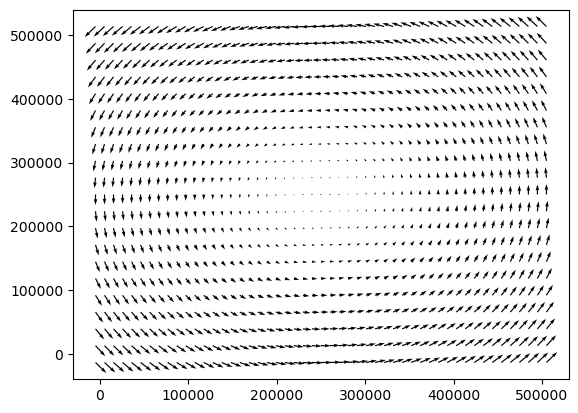

In [7]:
nx = 50
ny = 20
W = 5e5
H = W # force square domain

# Set up the regular grid:
grid = CartesianGrid(W,H,nx,ny)

# Set up the velocity arrays at the cell centers. 
# Note that the cell center arryas extend outside the domain (ghost nodes along left, right, top, bottom)
vx = zeros(ny+1,nx)
vy = zeros(ny,nx+1)

vxc = zeros(ny+1,nx+1)
vyc = zeros(ny+1,nx+1)

xvx = zeros(ny+1,nx)
yvx = zeros(ny+1,nx)

xvy = zeros(ny,nx+1)
yvy = zeros(ny,nx+1)

xc = zeros(ny+1,nx+1) # cell center positions
yc = copy(xc)

omega = 1.0 # rotation rate in rad/time

# VX and VY at cell centers:
for i in 1:ny+1
    for j in 1:nx+1
        xc[i,j] = grid.xc[j]
        yc[i,j] = grid.yc[i]
        
        theta = atan(grid.yc[i]-H/2,grid.xc[j]-W/2)
        r = sqrt((grid.xc[j]-W/2)^2 + (grid.yc[i]-H/2)^2)

        vx1 = -omega*r*sin(theta)
        vxc[i,j] = vx1
        vy1 =  omega*r*cos(theta)
        vyc[i,j] = vy1        
    end
end

# VX at VX nodes:
for i in 1:(ny+1)
    for j in 1:nx          
        # polar coordinates of the VX node (staggered in -y direction):
        theta = atan(grid.yc[i]-H/2,grid.x[j]-W/2)
        r = sqrt((grid.x[j]-W/2)^2 + (grid.yc[i]-H/2)^2)
        # velocity at the node:
        vx1 = -omega*r*sin(theta)
        vx[i,j] = vx1        
    end
end

# VY at VY nodes:
for i in 1:(ny)
    for j in 1:(nx+1)
        # polar coordinates of the VY node (staggered in -x direction):
        theta = atan(grid.y[i]-H/2,grid.xc[j]-W/2)
        r = sqrt((grid.xc[j]-W/2)^2 + (grid.y[i]-H/2)^2)
        vy1 = omega*r*cos(theta)
        vy[i,j] = vy1
    end
end

# make a figure showing the velocity field:
figure()
quiver(xc,yc,vxc,vyc)
show()

In [11]:
# number of markers per cell in x- and y-directions
markx = 1
marky = 1

# nsteps is a list of numbers of steps for which to run advection algorithms
nsteps = [100,500,1000,5000,10000]
dx2result = zeros(5,)
dx4result = zeros(5,)
for i in 1:5    
    markers  = Markers(grid,["T"],["material"] ; nmx=markx,nmy=marky,random=false)

    # remove markers that will travel outside size of domain
    r_domain = W/2
    mask = sqrt.((markers.x[1,:].-W/2).^2 + (markers.x[2,:].-H/2).^2) .< r_domain
    markers.x = markers.x[:,mask]
    markers.nmark = size(markers.x,2)
    markers4 = deepcopy(markers)
    # store the intial coordinates of the markers:
    x0 = copy(markers.x)
    
    # compute the size of the timestep:
    time = 0
    nstep = nsteps[i]
    dt = 2*pi/nstep # time step
    dt1=compute_timestep(grid,vxc,vyc,dtmax=dt)
    if dt>dt1
        # error("timstep too big")
    end
    
    # do the advection with both algorithms:
    for istep in 1:nstep
        move_markers_rk2!(markers,grid,vx,vy,dt,continuity_weight=0.0)
        move_markers_rk4!(markers4,grid,vx,vy,dt,continuity_weight=0.0)
        time += dt
    end
    # compute the deviation of each marker from its starting position and the 2-norm of the deviations.
    dx2 = markers.x-x0
    dx2 = sqrt.(dx2[1,:].^2 + dx2[2,:].^2)
    dx2norm = norm(dx2)

    dx4 = markers4.x-x0
    dx4 = sqrt.(dx4[1,:].^2 + dx4[2,:].^2)
    dx4norm = norm(dx4)
    
    # store the results:
    dx2result[i] = dx2norm
    dx4result[i] = dx4norm
end

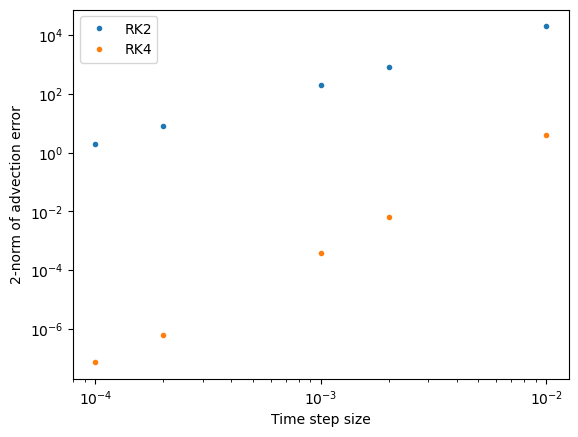

In [12]:
figure()
plot(1 ./nsteps,dx2result,".",label="RK2")
plot(1 ./nsteps,dx4result,".",label="RK4")
legend()
gca().set_yscale("log")
gca().set_xscale("log")
ylabel("2-norm of advection error")
xlabel("Time step size")
show()